<a href="https://colab.research.google.com/github/skj092/Object-Detection-with-Oxford-IIIT-Pet-Dataset/blob/main/iiit_object_detection_pets_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *

In [39]:
# path = untar_data(URLs.PETS,'/content')
path = Path('/content/oxford-iiit-pet')
Path.BASE_PATH  = path
path.ls()

(#2) [Path('images'),Path('annotations')]

In [40]:
annotations = get_files(path/'annotations/xmls', ".xml")
annotations

(#3686) [Path('annotations/xmls/basset_hound_181.xml'),Path('annotations/xmls/wheaten_terrier_124.xml'),Path('annotations/xmls/Birman_179.xml'),Path('annotations/xmls/japanese_chin_149.xml'),Path('annotations/xmls/keeshond_127.xml'),Path('annotations/xmls/newfoundland_184.xml'),Path('annotations/xmls/boxer_121.xml'),Path('annotations/xmls/english_cocker_spaniel_131.xml'),Path('annotations/xmls/havanese_144.xml'),Path('annotations/xmls/japanese_chin_175.xml')...]

In [44]:
images = get_image_files(path/'images')
images

(#7390) [Path('images/keeshond_112.jpg'),Path('images/yorkshire_terrier_102.jpg'),Path('images/english_cocker_spaniel_181.jpg'),Path('images/Siamese_205.jpg'),Path('images/miniature_pinscher_19.jpg'),Path('images/miniature_pinscher_20.jpg'),Path('images/pug_200.jpg'),Path('images/american_pit_bull_terrier_40.jpg'),Path('images/american_bulldog_127.jpg'),Path('images/beagle_33.jpg')...]

In [47]:
from ast import NameConstant
name = annotations[0].name.replace('.xml', '.jpg')
name

'basset_hound_181.jpg'

In [56]:
annotation_paths = get_files(path/'annotations/xmls', ".xml")
annotation_paths[0].name

'basset_hound_181.xml'

In [66]:
import os
from PIL import Image
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import Dataset

class PETS(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = get_image_files(path/'images')
        self.annotation_paths = get_files(path/'annotations/xmls', ".xml")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        annotation = self.annotation_paths[idx]
        img_name = annotation.name.replace('.xml', '.jpg')
        img_path = os.path.join(path/'images', img_name)

        image = Image.open(img_path).convert('RGB')

        # Load and process annotation file (e.g., parse XML or JSON)
        # Extract bounding box coordinates

        # if self.transform:
        #     image = self.transform(image)

        return image, annotation  # target should contain bounding box coordinates

# Usage
dataset = PETS(root_dir='path/to/oxford_iiit_pet_dataset', transform=None)


In [67]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=500x375>,
 Path('annotations/xmls/basset_hound_181.xml'))

In [74]:
xml_files = [file for file in os.listdir(os.path.join(path, 'annotations/xmls')) if file.endswith('.xml')]
xml_files[0]

'basset_hound_181.xml'

In [75]:
import os
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET

class CustomObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.xml_files = [file for file in os.listdir(os.path.join(path, 'annotations/xmls')) if file.endswith('.xml')]

    def __len__(self):
        return len(self.xml_files)

    def __getitem__(self, idx):
        xml_file = os.path.join(self.root_dir, 'annotations/xmls', self.xml_files[idx])
        img_name = os.path.splitext(self.xml_files[idx])[0] + '.jpg'
        img_path = os.path.join(self.root_dir, 'images', img_name)

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Load and parse XML annotation
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Extract image size
        width = int(root.find('size').find('width').text)
        height = int(root.find('size').find('height').text)

        # Initialize lists for target data
        boxes = []
        labels = []

        # Extract bounding box information
        for obj in root.findall('object'):
            label = obj.find('name').text
            xmin = int(obj.find('bndbox').find('xmin').text)
            ymin = int(obj.find('bndbox').find('ymin').text)
            xmax = int(obj.find('bndbox').find('xmax').text)
            ymax = int(obj.find('bndbox').find('ymax').text)

            # Append bounding box coordinates and label
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        # Convert boxes and labels to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.tensor([labels.index(label) for label in labels], dtype=torch.int64)

        # Calculate area (optional)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Define iscrowd (optional)
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        # Create target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transform:
            img, target = self.transform(img, target)

        return img, target


In [82]:
ds = CustomObjectDetectionDataset(path)

In [83]:
ds[0]

(<PIL.Image.Image image mode=RGB size=500x375>,
 {'boxes': tensor([[ 34.,   1., 411., 375.]]),
  'labels': tensor([0]),
  'image_id': tensor([0]),
  'area': tensor([140998.]),
  'iscrowd': tensor([0])})

In [84]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dataset_sample(dataset, index, class_names=None):
    """
    Visualizes a single data sample from a dataset.

    Args:
        dataset (Dataset): The PyTorch dataset containing the data samples.
        index (int): The index of the data sample to visualize.
        class_names (list): Optional list of class names corresponding to label indices.
    """
    sample = dataset[index]
    image, target = sample

    image = np.array(image)
    boxes = target["boxes"].numpy()
    labels = target["labels"].numpy()

    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)

        if class_names:
            label_name = class_names[label]
        else:
            label_name = str(label)

        plt.text(xmin, ymin, label_name, backgroundcolor='red', color='white', fontsize=8)

    plt.show()

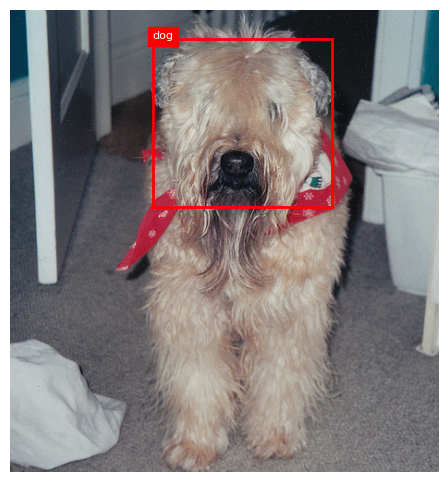

In [85]:
visualize_dataset_sample(ds, 1, class_names=['dog', 'cat'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_batch_with_annotations(batch, class_names=None):
    """
    Visualizes a batch of images with bounding box annotations.

    Args:
        batch (list): List of images and their corresponding annotations.
                      Each element in the list should be a tuple (image, target),
                      where 'image' is a PIL image and 'target' is the annotation dictionary.
        class_names (list): Optional list of class names corresponding to label indices.
    """
    num_images = len(batch)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, (image, target) in enumerate(batch):
        image = np.array(image)
        boxes = target["boxes"].numpy()
        labels = target["labels"].numpy()

        axes[i].imshow(image)
        axes[i].axis('off')

        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            rect = plt.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2)
            axes[i].add_patch(rect)

            if class_names:
                label_name = class_names[label]
            else:
                label_name = str(label)

            axes[i].text(xmin, ymin, label_name, backgroundcolor='red', color='white', fontsize=8)

    plt.show()

# Usage example:
# Assuming you have a batch of images and annotations (e.g., batch = [(image1, target1), (image2, target2), ...])
# You can call the function like this:
# visualize_batch_with_annotations(batch, class_names=["cat", "dog"])


In [93]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float))
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [87]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [95]:
import utils
import torchvision


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = CustomObjectDetectionDataset(path, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss_classifier': tensor(0.1640, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0., grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0143, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0101, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [97]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2,
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 54.7MB/s]


In [98]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes,
    )

    return model

In [99]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = CustomObjectDetectionDataset(path, get_transform(train=True))
# dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# data_loader_test = torch.utils.data.DataLoader(
#     dataset_test,
#     batch_size=1,
#     shuffle=False,
#     num_workers=4,
#     collate_fn=utils.collate_fn
# )

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 132MB/s]


ValueError: ignored